In [15]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

from models import RegressionLSTMBayes

In [2]:
%matplotlib inline

We will use a auto regression model as example(dataset).

$$
\begin{align}
X_t &= \sum_{i=1}^5 \beta_i X_{t-i} + \epsilon_i \\
\epsilon_i &\sim N(0,\sigma^2) 
\end{align}
$$

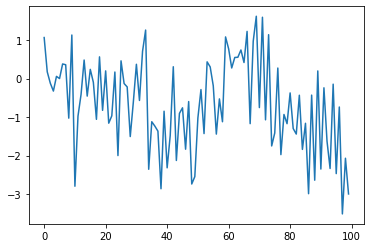

In [6]:
L = 100
x = torch.empty(L)

x[:5] = torch.randn(5)
beta = torch.tensor([0.01, 0.05, 0.1, 0.2, 0.5])

for t in range(6, 100):
    x[t] = x[t-6:t-1] @ beta + torch.randn(1)
    
plt.plot(x.numpy())
plt.show()

Instead of using fixed dataset, we will sample new data for every optimzing step. 

$$
X_{1:5} \sim N(0,1)
$$

In [69]:
batch = 6
def sample_data(L = None):
    if L is None:
        L = random.randint(10,100)

    x = torch.empty(L, batch)
    x[:5, :] = torch.randn(5, batch)

    for t in range(5, L):
        x[t, :] = beta @ x[t-5: t, :] + torch.randn(batch)

    x_input = x.unsqueeze(2)[:-1, :, :]
    target = x[-1,:]
    
    return x_input, target


In [ ]:
lstm_bayes = RegressionLSTMBayes(1, 5)
#optimizer = torch.optim.SGD(lstm_reg.parameters(), 0.1)
optimizer = torch.optim.Adam(lstm_bayes.parameters(), 0.01)

n_iter = 300
loss_list = []

for i in range(n_iter):
    x_input, target = sample_data()
    
    optimizer.zero_grad()
    
    pred = lstm_bayes(x_input)
    loss = F.smooth_l1_loss(pred, target)
    loss.backward()
    
    loss_list.append(loss.item())
    print("Iteration: {}/{} loss:{}".format(i+1, n_iter, loss))
    if torch.isnan(loss):
        print("nan detected, break")
        break
    
    optimizer.step()

Iteration: 1/300 loss:0.8867640495300293
Iteration: 2/300 loss:0.45192408561706543
Iteration: 3/300 loss:0.7911667823791504
Iteration: 4/300 loss:1.1099721193313599
Iteration: 5/300 loss:0.31090235710144043
Iteration: 6/300 loss:1.1438411474227905
Iteration: 7/300 loss:0.6343778967857361
Iteration: 8/300 loss:0.6850128173828125
Iteration: 9/300 loss:0.8745198249816895
Iteration: 10/300 loss:1.0287421941757202
Iteration: 11/300 loss:0.7082139849662781
Iteration: 12/300 loss:0.9590644836425781
Iteration: 13/300 loss:1.0837154388427734
Iteration: 14/300 loss:1.1005425453186035
Iteration: 15/300 loss:0.3935685455799103
Iteration: 16/300 loss:0.7357041239738464
Iteration: 17/300 loss:1.1170662641525269
Iteration: 18/300 loss:0.675970733165741
Iteration: 19/300 loss:0.796799898147583
Iteration: 20/300 loss:1.2403367757797241
Iteration: 21/300 loss:0.9029118418693542
Iteration: 22/300 loss:0.7805319428443909
Iteration: 23/300 loss:0.6315945982933044
Iteration: 24/300 loss:0.8640006184577942
I

In [ ]:
plt.plot(loss_list)

In [65]:
x_input, target = sample_data(100)
x_trace = x_input[:,0,0]

In [66]:
num_particle = 30
with torch.no_grad():
    output, _ = lstm_bayes.rnn(x_trace.unsqueeze(1).unsqueeze(1).expand(x_trace.shape[0], num_particle, 1))
output.shape

torch.Size([99, 30, 5])

In [67]:
lin_output = lstm_bayes.linear(output)
lin_output.shape

torch.Size([99, 30, 1])

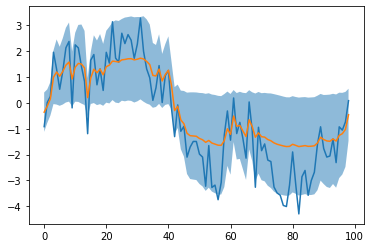

In [68]:
lo = lin_output.squeeze(2).detach().numpy()
mu = lo.mean(1)
std = lo.std(1)

import numpy as np
plt.plot(x_trace.numpy())

plt.plot(mu)
plt.fill_between(np.arange(mu.shape[0]) ,mu - std*3, mu + std*3, alpha=0.5)
plt.savefig("images/sigma1.svg")

The above example set $\sigma = 1$, what will happen if we use $\sigma=0.1$, considering we don't specify a parameter to denote the "common noise"?

In [38]:
batch = 6
def sample_data(L = None):
    if L is None:
        L = random.randint(10,100)

    x = torch.empty(L, batch)
    x[:5, :] = torch.randn(5, batch) * 0.1 # change it if you want

    for t in range(5, L):
        x[t, :] = beta @ x[t-5: t, :] + torch.randn(batch) * 0.1 # change it if you want

    x_input = x.unsqueeze(2)[:-1, :, :]
    target = x[-1,:]
    
    return x_input, target


In [39]:
lstm_bayes = RegressionLSTMBayes(1, 5)
#optimizer = torch.optim.SGD(lstm_reg.parameters(), 0.1)
optimizer = torch.optim.Adam(lstm_bayes.parameters(), 0.01)

n_iter = 300
loss_list = []

for i in range(n_iter):
    x_input, target = sample_data()
    
    optimizer.zero_grad()
    
    pred = lstm_bayes(x_input)
    loss = F.smooth_l1_loss(pred, target)
    loss.backward()
    
    loss_list.append(loss.item())
    print("Iteration: {}/{} loss:{}".format(i+1, n_iter, loss))
    if torch.isnan(loss):
        print("nan detected, break")
        break
    
    optimizer.step()

Iteration: 1/300 loss:0.026921356096863747
Iteration: 2/300 loss:0.016862820833921432
Iteration: 3/300 loss:0.02621559239923954
Iteration: 4/300 loss:0.007959927432239056
Iteration: 5/300 loss:0.026710383594036102
Iteration: 6/300 loss:0.010384859517216682
Iteration: 7/300 loss:0.005915982648730278
Iteration: 8/300 loss:0.05071970447897911
Iteration: 9/300 loss:0.0046854750253260136
Iteration: 10/300 loss:0.002171949716284871
Iteration: 11/300 loss:0.01941617764532566
Iteration: 12/300 loss:0.023117905482649803
Iteration: 13/300 loss:0.0024984886404126883
Iteration: 14/300 loss:0.007916313596069813
Iteration: 15/300 loss:0.021394552662968636
Iteration: 16/300 loss:0.02293870411813259
Iteration: 17/300 loss:0.012614634819328785
Iteration: 18/300 loss:0.021176917478442192
Iteration: 19/300 loss:0.009529851377010345
Iteration: 20/300 loss:0.007521016523241997
Iteration: 21/300 loss:0.004723263438791037
Iteration: 22/300 loss:0.018095538020133972
Iteration: 23/300 loss:0.042987097054719925

Iteration: 185/300 loss:0.008641608990728855
Iteration: 186/300 loss:0.003959283698350191
Iteration: 187/300 loss:0.011707574129104614
Iteration: 188/300 loss:0.009517858736217022
Iteration: 189/300 loss:0.004495580215007067
Iteration: 190/300 loss:0.003302258439362049
Iteration: 191/300 loss:0.008186804130673409
Iteration: 192/300 loss:0.013510603457689285
Iteration: 193/300 loss:0.0039610969834029675
Iteration: 194/300 loss:0.004303015302866697
Iteration: 195/300 loss:0.0016171358292922378
Iteration: 196/300 loss:0.011953824199736118
Iteration: 197/300 loss:0.0062172915786504745
Iteration: 198/300 loss:0.011982130818068981
Iteration: 199/300 loss:0.007635827641934156
Iteration: 200/300 loss:0.0031351980287581682
Iteration: 201/300 loss:0.005098377820104361
Iteration: 202/300 loss:0.006488302256911993
Iteration: 203/300 loss:0.010225527919828892
Iteration: 204/300 loss:0.00469307042658329
Iteration: 205/300 loss:0.01825551874935627
Iteration: 206/300 loss:0.011230138130486012
Iteratio

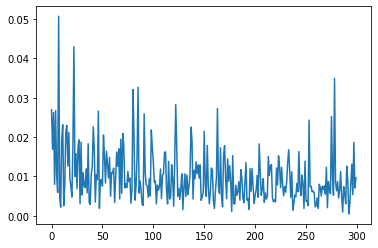

In [40]:
plt.plot(loss_list)

In [45]:
x_input, target = sample_data()
x_trace = x_input[:,0,0]

In [46]:
num_particle = 30
with torch.no_grad():
    output, _ = lstm_bayes.rnn(x_trace.unsqueeze(1).unsqueeze(1).expand(x_trace.shape[0], num_particle, 1))
output.shape

torch.Size([98, 30, 5])

In [47]:
lin_output = lstm_bayes.linear(output)
lin_output.shape

torch.Size([98, 30, 1])

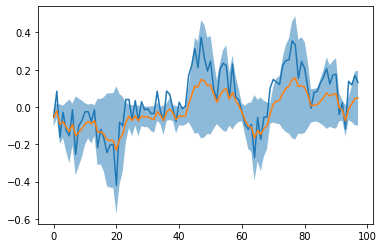

In [51]:
lo = lin_output.squeeze(2).detach().numpy()
mu = lo.mean(1)
std = lo.std(1)

import numpy as np
plt.plot(x_trace.numpy())

plt.plot(mu)
plt.fill_between(np.arange(mu.shape[0]) ,mu - std*3, mu + std*3, alpha=0.5)
plt.savefig("images/sigma01.svg")

<Figure size 432x288 with 0 Axes>

Interestingly, even we don't specify a specialized parameter, the result seems resonable.